Imports

In [145]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import copy     # for deepcopy


1. Load the data and preprocess it

In [146]:
# Load documents
def lemmatize_stemming(text):
        stemmer = SnowballStemmer("english")
        return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

try: #if the data is already downloaded
    docs = pickle.load(open("data/docs.pkl", "rb"))
    dictionary = pickle.load(open("data/dictionary.pkl", "rb"))
except:
    newsgroups_train = fetch_20newsgroups(subset='train')
    print(len(newsgroups_train.data), " documents loaded.")

    print("Example document:")
    print(newsgroups_train.data[0])


    # Preprocess documents - lemmatization and stemming

    processed_docs = list(map(preprocess, newsgroups_train.data))

    print("Example document - lemmatized and stemmed:")
    print(processed_docs[0])


    # Construct dictionary

    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

    # Filter words in documents

    docs = list()
    maxdoclen = 0 
    for doc in processed_docs:
        docs.append(list(filter(lambda x: x != -1, dictionary.doc2idx(doc))))
        maxdoclen = max(maxdoclen, len(docs[-1]))

    #saving docs and dictionary
    with open('data/docs.pkl', 'wb') as f:
        pickle.dump(docs, f)
    with open('data/dictionary.pkl', 'wb') as f:
        pickle.dump(dictionary, f)

print("Dictionary size: ", len(dictionary))

print("Example document - filtered:")
print(docs[0])

Dictionary size:  6591
Example document - filtered:
[29, 20, 11, 30, 17, 5, 21, 31, 9, 6, 27, 15, 14, 7, 4, 6, 25, 0, 3, 24, 23, 1, 13, 18, 8, 26, 32, 22, 10, 12, 15, 16, 28, 2, 19]


2. LDA Implementation

Base functions

In [147]:
# Number of topics, alpha, and gamma values
K = 20
alpha = 0.1
gamma = 0.1
max_iterations = 50
# Function to initialize random topic assignments for each word in documents
def init_z(docs, K):
    return [np.random.randint(0, K, size=len(doc)) for doc in docs]
# Calculate counts of various parameters used in LDA
def counts(docs, dictionary, z, K):
    c_d = np.zeros((len(docs), K))  # Counts of words in documents for each topic
    c_w = np.zeros((len(dictionary), K))  # Counts of words assigned to topics
    c_t = np.zeros((K,))  # Counts of words assigned to each topic overall

    for d, doc in enumerate(docs):
        for i, w in enumerate(doc):
            k = z[d][i]
            c_d[d][k] += 1
            c_w[w][k] += 1
            c_t[k] += 1
    return c_d, c_w, c_t
# Compute entropy of each topic based on counts
def compute_entropy(c_d, c_w, c_t, K, gamma):
    entropies = np.zeros(K)
    for topic in range(K):
        sum_words = np.sum(c_w[:, topic])
        topic_prob = (gamma + c_w[:, topic]) / (gamma * len(c_w[:, topic]) + sum_words)
        entropies[topic] = -np.sum(topic_prob * np.log2(topic_prob))
    return entropies
# Latent Dirichlet Allocation (LDA) algorithm implementation
def lda(docs, dictionary, K, num_iter, alpha, gamma):
    dictionary_size = len(dictionary)
    z = init_z(docs, K)
    c_d, c_w, c_t = counts(docs, dictionary, z, K)
    data_per_iteration = []
    entropies_per_iteration = []

    for i in range(num_iter):
        for d, doc in enumerate(docs):
            len_doc = len(doc)
            for w in range(len_doc):
                actual_z = z[d][w]
                word = doc[w]
                # Update counts by decrementing values
                c_d[d][actual_z] -= 1
                c_w[word][actual_z] -= 1
                c_t[actual_z] -= 1
                # Calculate probabilities for the new topic assignment
                p = np.multiply((alpha + c_d[d, :]) / (K * alpha + len_doc - 1),
                                (gamma + c_w[word, :]) / (gamma * dictionary_size + c_t[:]))
                p /= np.sum(p)
                # Sample a new topic for the word based on probabilities
                new_z = np.random.choice(range(K), p=p)
                z[d][w] = new_z
                # Update counts by incrementing values
                c_d[d][new_z] += 1
                c_w[word][new_z] += 1
                c_t[new_z] += 1
        # Track data and entropies per iteration
        data_per_iteration.append((np.copy(c_d), np.copy(c_w), np.copy(c_t), copy.deepcopy(z)))
        entropies_per_iteration.append(compute_entropy(c_d, c_w, c_t, K, gamma))
    # Return topic assignments, counts, and iteration-specific data
    return z, c_d, c_w, c_t, data_per_iteration, entropies_per_iteration


Computation

In [148]:
# Run LDA
try:
    z = pickle.load(open("data/z.pkl", "rb"))
    c_d = pickle.load(open("data/c_d.pkl", "rb"))
    c_w = pickle.load(open("data/c_w.pkl", "rb"))
    c_t = pickle.load(open("data/c_t.pkl", "rb"))
    data_per_iteration = pickle.load(open("data/data_per_iteration.pkl", "rb"))
    entropies_per_iteration = pickle.load(open("data/entropies_per_iteration.pkl", "rb"))
except:
    z, c_d, c_w, c_t, data_per_iteration, entropies_per_iteration = lda(docs, dictionary, K, max_iterations, alpha, gamma)
    #save the obtained results
    with open('data/z.pkl', 'wb') as f:
        pickle.dump(z, f)
    with open('data/c_d.pkl', 'wb') as f:
        pickle.dump(c_d, f)
    with open('data/c_w.pkl', 'wb') as f:
        pickle.dump(c_w, f)
    with open('data/c_t.pkl', 'wb') as f:
        pickle.dump(c_t, f)
    with open('data/data_per_iteration.pkl', 'wb') as f:
        pickle.dump(data_per_iteration, f)
    with open('data/entropies_per_iteration.pkl', 'wb') as f:
        pickle.dump(entropies_per_iteration, f)

3. Result analysis

Base functions

In [149]:
def plot_topic_distribution_per_iteration(iteration, K, c_d, doc_index):
    plt.figure(figsize=(8,4))
    plt.bar(range(K), c_d[doc_index, :])
    plt.xlabel("Topic")
    plt.ylabel("Word count")
    plt.title("Topic distribution for document {} in iteration {}".format(doc_index, iteration))
    plt.show()

def plot_per_topic_entropy(entropies_per_iteration, K):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(entropies_per_iteration)), entropies_per_iteration)
    plt.xlabel("Iteration")
    plt.ylabel("Entropy")
    plt.title("Entropy per topic")
    plt.show()

def plot_most_frequent_words(dictionary, word_num, topic, iteration_data):
    c_w = iteration_data[1]
    top_words = np.argsort(c_w[:, topic])[::-1][:word_num]
    top_words = [dictionary[word] for word in top_words]
    top_words_count = [c_w[word, topic] for word in np.argsort(c_w[:, topic])[::-1][:word_num]]
    plt.figure(figsize=(8, 4))
    plt.bar(top_words, top_words_count)
    plt.xlabel("Word")
    plt.ylabel("Word count")
    plt.title("Most frequent words for topic {}".format(topic))
    plt.show()



Plotting

In [150]:
#longest document index
longest_doc_index = np.argmax([len(doc) for doc in docs])

Topic distribution visualization

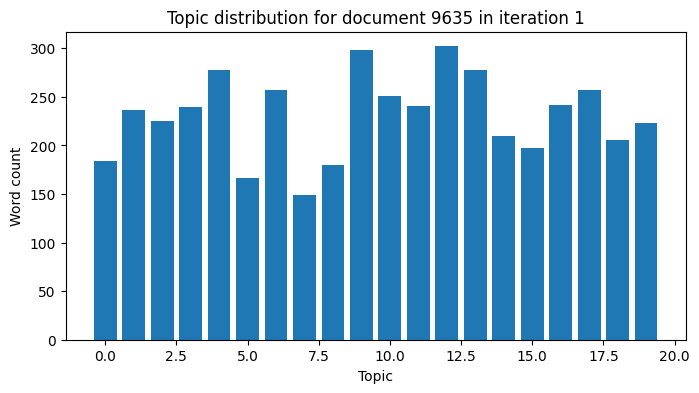

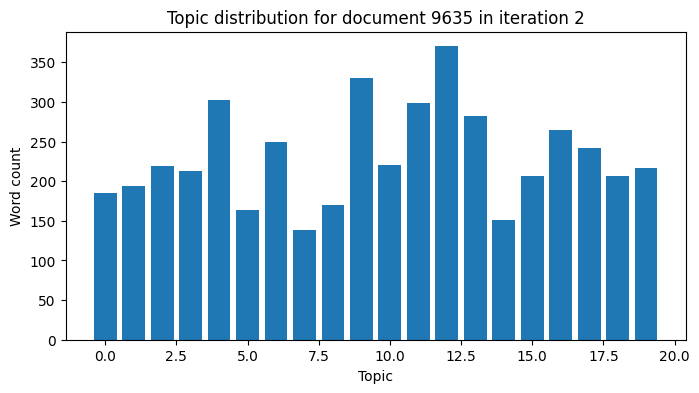

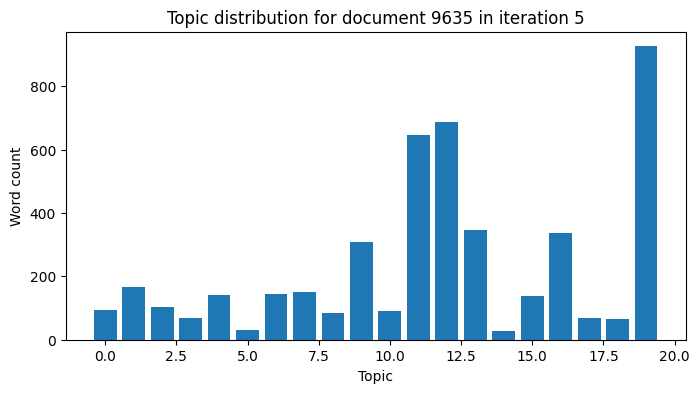

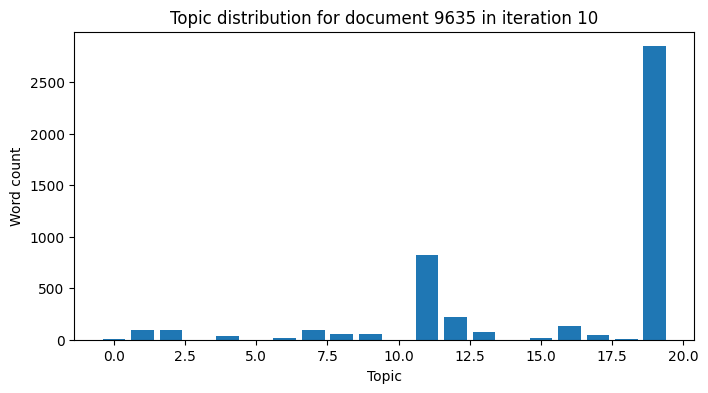

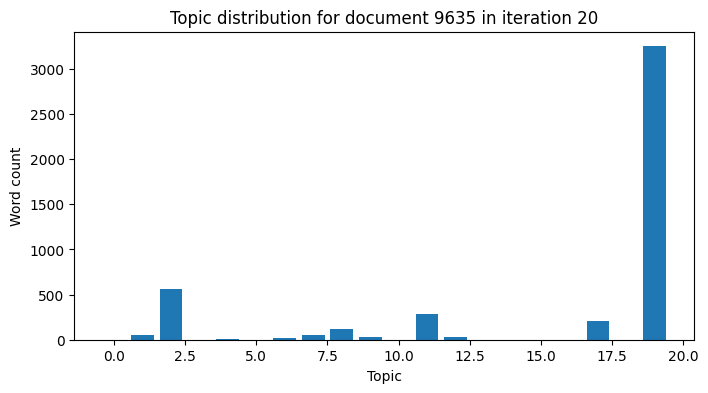

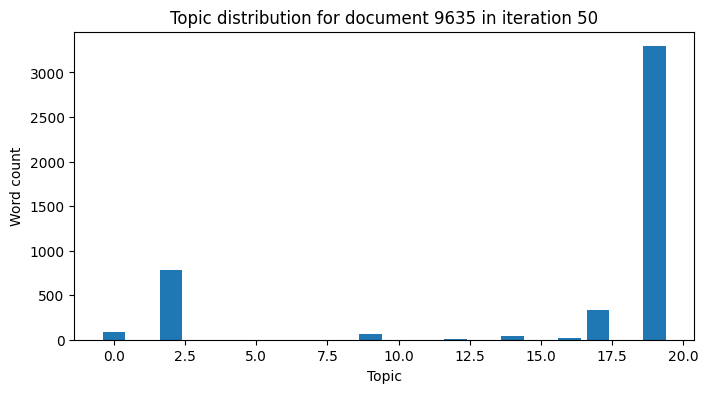

In [151]:
# Plot topic distribution for longest document in iterations [1,2,5,10,20,50]
for i in [1, 2, 5, 10, 20, 50]:
    plot_topic_distribution_per_iteration(i, K, data_per_iteration[i-1][0], longest_doc_index)

**Question 2**

We can see here the convergence of the LDA model. First, the words are almost equally distributed which seems logical. Then, it moves a lot until the 20th iterations where we could almost say that it converged. There are not much more movement from 20th to 50th iteration.

Word entropy as a function of Gibbs iterations

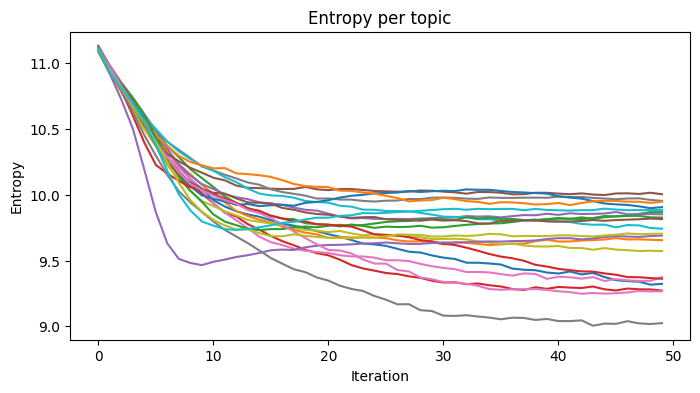

In [152]:
plot_per_topic_entropy(entropies_per_iteration, K)

Most frequent 20 words for 3 differents topics

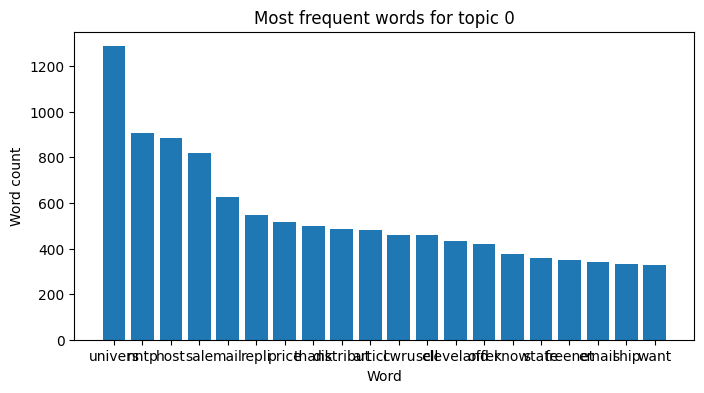

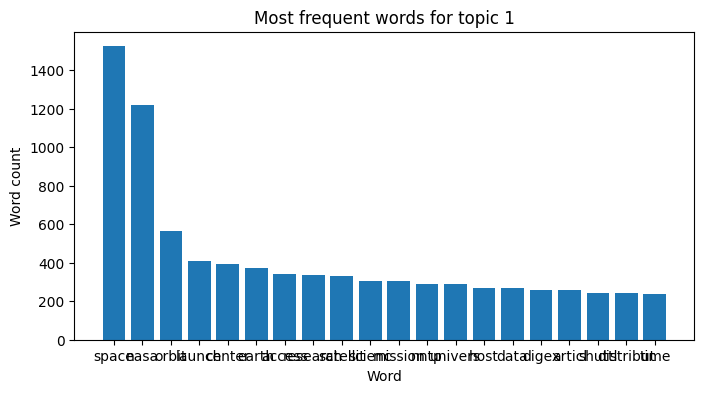

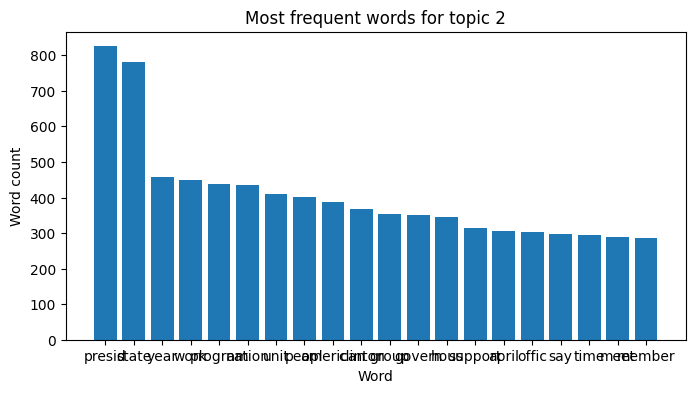

In [153]:
topics_to_plot = [0,1,2]
num_words = 20
for topic in topics_to_plot:
    plot_most_frequent_words(dictionary, num_words, topic, data_per_iteration[-1])


**Question 4**

*Topic 1 :* The first topic seems to be around shopping, sales etc...

*Topic 2 :* The second topic is clearly about space, research in space, science topics etc...

*Topic 3 :* The last one is probably about politics / elections etc...

**PART 2 :** Test data

Load and preprocess the test data

In [154]:
#load test data and preprocess it the same as train data
try:
    test_docs = pickle.load(open("data/test_docs.pkl", "rb"))
except:
    newsgroups_test = fetch_20newsgroups(subset='test')
    processed_docs_test = list(map(preprocess, newsgroups_test.data))
    test_docs = list()
    for doc in processed_docs_test:
        test_docs.append(list(filter(lambda x: x != -1, dictionary.doc2idx(doc))))
    #save the obtained results
    with open('data/test_docs.pkl', 'wb') as f:
        pickle.dump(test_docs, f)

print(len(test_docs), " documents loaded.")
print("Example document - filtered:")
print(test_docs[0])

7532  documents loaded.
Example document - filtered:
[729, 2363, 280, 12, 30, 729, 120, 220, 715, 20, 11, 729, 536, 3475, 18, 107, 222, 499, 627, 124, 201, 13, 855, 226, 1018, 18, 855, 226, 445, 839, 3163, 152, 32, 107, 2099, 7, 147, 853, 152, 2363]


Count function to compute entropy

In [155]:
def test_counts(alpha, gamma, K, lda_c_w, lda_c_t, test_docs, max_iterations):
    c_d = np.zeros((len(test_docs), K))  # Counts of words in documents for each topic
    z_nd = init_z(test_docs, K)
    word_count = 0
    for d, doc in enumerate(test_docs):
        for i, w in enumerate(doc):
            k = z_nd[d][i]
            c_d[d][k] += 1
            word_count += 1

    for i in range(max_iterations):
        for d, doc in enumerate(test_docs):
            len_doc = len(doc)
            for w in range(len_doc):
                actual_z = z_nd[d][w]
                word = doc[w]
                # Update counts by decrementing values
                c_d[d][actual_z] -= 1
                # Calculate probabilities for the new topic assignment
                p = np.multiply((alpha + c_d[d, :]) / (K * alpha + len_doc - 1),
                                (gamma + lda_c_w[word, :]) / (gamma * len(lda_c_w[:, 0]) + lda_c_t[:]))
                p /= np.sum(p)
                # Sample a new topic for the word based on probabilities
                new_z = np.random.choice(range(K), p=p)
                z_nd[d][w] = new_z
                # Update counts by incrementing values
                c_d[d][new_z] += 1
    return c_d, z_nd, word_count
    

In [156]:
try:
    test_c_d = pickle.load(open("data/test_c_d.pkl", "rb"))
    test_z = pickle.load(open("data/test_z.pkl", "rb"))
    word_count_test = pickle.load(open("data/word_count_test.pkl", "rb"))
except:
    test_c_d, test_z, word_count_test = test_counts(alpha, gamma, K, c_w, c_t, test_docs, 10)
    #save the obtained results
    with open('data/test_c_d.pkl', 'wb') as f:
        pickle.dump(test_c_d, f)
    with open('data/test_z.pkl', 'wb') as f:
        pickle.dump(test_z, f)
    with open('data/word_count_test.pkl', 'wb') as f:
        pickle.dump(word_count_test, f)

Entropy function

In [157]:
def compute_perplexity(K, alpha, gamma, dictionary, c_d_test, word_count_test, lda_c_w, lda_c_t):
    entropy_per_topic = np.array([np.sum(lda_c_w[:, topic]) for topic in range(K)])
    dict_len = len(dictionary)
    entropy = 0
    for d, doc in enumerate(test_docs):
        for i, w in enumerate(doc):
            p = np.multiply((alpha + c_d_test[d, :]) / (K * alpha + len(doc) - 1),
                            (gamma + lda_c_w[w, :]) / (entropy_per_topic + gamma * dict_len))
            entropy += np.log2(np.sum(p))
    entropy = -entropy / word_count_test
    return entropy, 2 ** entropy


Computation

In [158]:
#entropy and perplexity for test data
test_entropy, test_perplexity = compute_perplexity(K, alpha, gamma, dictionary, test_c_d, word_count_test, c_w, c_t)
print("Test entropy: ", test_entropy)
print("Test perplexity: ", test_perplexity)

Test entropy:  10.500436535779201
Test perplexity:  1448.5929419494787


Simple Bayesian Model Entropy & Perplexity Calculation

In [159]:
def simple_bayesian_model_perplexity(gamma, docs, dictionary):
    dict_len = len(dictionary)
    counts = np.zeros(dict_len)
    for doc in docs:
        for word in doc:
            counts[word] += 1
    word_count = np.sum(counts)
    entropy = 0
    for doc in docs:
        for word in doc:
            entropy += np.log2((gamma + counts[word]) / (dict_len * gamma + word_count))
    entropy /= -word_count
    return entropy, 2 ** entropy

Computation

In [160]:
simple_bayesian_model_entropy, simple_bayesian_model_perplexity = simple_bayesian_model_perplexity(gamma, test_docs, dictionary)
print("Simple Bayesian model entropy: ", simple_bayesian_model_entropy)
print("Simple Bayesian model perplexity: ", simple_bayesian_model_perplexity)

Simple Bayesian model entropy:  11.290558490796458
Simple Bayesian model perplexity:  2504.936802963189


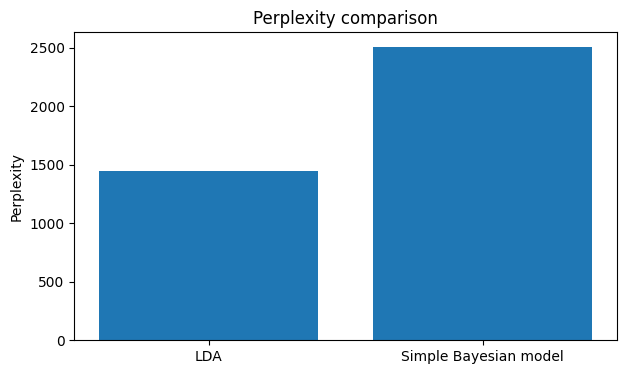

In [161]:
#Compare perplexity of LDA and simple Bayesian model
plt.figure(figsize=(7, 4))
plt.bar(["LDA", "Simple Bayesian model"], [test_perplexity, simple_bayesian_model_perplexity])
plt.ylabel("Perplexity")
plt.title("Perplexity comparison")
plt.show()

**Question 5**

We can see here that our model works better than the simple bayesian one, which is a good sign !

**Question 6**

In this part we will try different combinaison of parameters for our LDA algorithm to see how it performs.

In [162]:
#first try for different model parameters
try:
    z_1 = pickle.load(open("data/q6/z_1.pkl", "rb"))
    c_d_1 = pickle.load(open("data/q6/c_d_1.pkl", "rb"))
    c_w_1 = pickle.load(open("data/q6/c_w_1.pkl", "rb"))
    c_t_1 = pickle.load(open("data/q6/c_t_1.pkl", "rb"))
    data_per_iteration_1 = pickle.load(open("data/q6/data_per_iteration_1.pkl", "rb"))
    entropies_per_iteration_1 = pickle.load(open("data/q6/entropies_per_iteration_1.pkl", "rb"))
    z_1_test = pickle.load(open("data/q6/z_1_test.pkl", "rb"))
    c_d_1_test = pickle.load(open("data/q6/c_d_1_test.pkl", "rb"))
    word_count_1_test = pickle.load(open("data/q6/word_count_1_test.pkl", "rb"))
except:
    K_1 = 20
    alpha_1 = 0.3
    gamma_1 = 0.3
    max_iterations_1 = 40
    z_1, c_d_1, c_w_1, c_t_1, data_per_iteration_1, entropies_per_iteration_1 = lda(docs, dictionary, K_1, max_iterations_1, alpha_1, gamma_1)
    z_1_test, c_d_1_test, word_count_1_test = test_counts(alpha_1, gamma_1, K_1, c_w_1, c_t_1, test_docs, 10)
    #save the obtained results
    with open('data/q6/z_1.pkl', 'wb') as f:
        pickle.dump(z_1, f)
    with open('data/q6/c_d_1.pkl', 'wb') as f:
        pickle.dump(c_d_1, f)
    with open('data/q6/c_w_1.pkl', 'wb') as f:
        pickle.dump(c_w_1, f)
    with open('data/q6/c_t_1.pkl', 'wb') as f:
        pickle.dump(c_t_1, f)
    with open('data/q6/data_per_iteration_1.pkl', 'wb') as f:
        pickle.dump(data_per_iteration_1, f)
    with open('data/q6/entropies_per_iteration_1.pkl', 'wb') as f:
        pickle.dump(entropies_per_iteration_1, f)
    with open('data/q6/z_1_test.pkl', 'wb') as f:
        pickle.dump(z_1_test, f)
    with open('data/q6/c_d_1_test.pkl', 'wb') as f:
        pickle.dump(c_d_1_test, f)
    with open('data/q6/word_count_1_test.pkl', 'wb') as f:
        pickle.dump(word_count_1_test, f)

In [163]:
#second try for different model parameters
try:
    z_2 = pickle.load(open("data/q6/z_2.pkl", "rb"))
    c_d_2 = pickle.load(open("data/q6/c_d_2.pkl", "rb"))
    c_w_2 = pickle.load(open("data/q6/c_w_2.pkl", "rb"))
    c_t_2 = pickle.load(open("data/q6/c_t_2.pkl", "rb"))
    data_per_iteration_2 = pickle.load(open("data/q6/data_per_iteration_2.pkl", "rb"))
    entropies_per_iteration_2 = pickle.load(open("data/q6/entropies_per_iteration_2.pkl", "rb"))
    z_2_test = pickle.load(open("data/q6/z_2_test.pkl", "rb"))
    c_d_2_test = pickle.load(open("data/q6/c_d_2_test.pkl", "rb"))
    word_count_2_test = pickle.load(open("data/q6/word_count_2_test.pkl", "rb"))
except:
    K_2 = 12
    alpha_2 = 0.1
    gamma_2 = 0.1
    max_iterations_2 = 40
    z_2, c_d_2, c_w_2, c_t_2, data_per_iteration_2, entropies_per_iteration_2 = lda(docs, dictionary, K_2, max_iterations_2, alpha_2, gamma_2)
    z_2_test, c_d_2_test, word_count_2_test = test_counts(alpha_2, gamma_2, K_2, c_w_2, c_t_2, test_docs, 10)
    with open('data/q6/z_2.pkl', 'wb') as f:
        pickle.dump(z_2, f)
    with open('data/q6/c_d_2.pkl', 'wb') as f:
        pickle.dump(c_d_2, f)
    with open('data/q6/c_w_2.pkl', 'wb') as f:
        pickle.dump(c_w_2, f)
    with open('data/q6/c_t_2.pkl', 'wb') as f:
        pickle.dump(c_t_2, f)
    with open('data/q6/data_per_iteration_2.pkl', 'wb') as f:
        pickle.dump(data_per_iteration_2, f)
    with open('data/q6/entropies_per_iteration_2.pkl', 'wb') as f:
        pickle.dump(entropies_per_iteration_2, f)
    with open('data/q6/z_2_test.pkl', 'wb') as f:
        pickle.dump(z_2_test, f)
    with open('data/q6/c_d_2_test.pkl', 'wb') as f:
        pickle.dump(c_d_2_test, f)
    with open('data/q6/word_count_2_test.pkl', 'wb') as f:
        pickle.dump(word_count_2_test, f)

In [164]:
#third try for different model parameters
try:
    z_3 = pickle.load(open("data/q6/z_3.pkl", "rb"))
    c_d_3 = pickle.load(open("data/q6/c_d_3.pkl", "rb"))
    c_w_3 = pickle.load(open("data/q6/c_w_3.pkl", "rb"))
    c_t_3 = pickle.load(open("data/q6/c_t_3.pkl", "rb"))
    data_per_iteration_3 = pickle.load(open("data/q6/data_per_iteration_3.pkl", "rb"))
    entropies_per_iteration_3 = pickle.load(open("data/q6/entropies_per_iteration_3.pkl", "rb"))
    z_3_test = pickle.load(open("data/q6/z_3_test.pkl", "rb"))
    c_d_3_test = pickle.load(open("data/q6/c_d_3_test.pkl", "rb"))
    word_count_3_test = pickle.load(open("data/q6/word_count_3_test.pkl", "rb"))
except:
    K_3 = 12
    alpha_3 = 0.3
    gamma_3 = 0.3
    max_iterations_3 = 40
    z_3, c_d_3, c_w_3, c_t_3, data_per_iteration_3, entropies_per_iteration_3 = lda(docs, dictionary, K_3, max_iterations_3, alpha_3, gamma_3)
    z_3_test, c_d_3_test, word_count_3_test = test_counts(alpha_3, gamma_3, K_3, c_w_3, c_t_3, test_docs, 10)
    #save the obtained results
    with open('data/q6/z_3.pkl', 'wb') as f:
        pickle.dump(z_3, f)
    with open('data/q6/c_d_3.pkl', 'wb') as f:
        pickle.dump(c_d_3, f)
    with open('data/q6/c_w_3.pkl', 'wb') as f:
        pickle.dump(c_w_3, f)
    with open('data/q6/c_t_3.pkl', 'wb') as f:
        pickle.dump(c_t_3, f)
    with open('data/q6/data_per_iteration_3.pkl', 'wb') as f:
        pickle.dump(data_per_iteration_3, f)
    with open('data/q6/entropies_per_iteration_3.pkl', 'wb') as f:
        pickle.dump(entropies_per_iteration_3, f)
    with open('data/q6/z_3_test.pkl', 'wb') as f:
        pickle.dump(z_3_test, f)
    with open('data/q6/c_d_3_test.pkl', 'wb') as f:
        pickle.dump(c_d_3_test, f)
    with open('data/q6/word_count_3_test.pkl', 'wb') as f:
        pickle.dump(word_count_3_test, f)

Comparing results

In [165]:
test_entropy_1, test_perplexity_1 = compute_perplexity(K_1, alpha_1, gamma_1, dictionary, z_1_test, word_count_1_test, c_w_1, c_t_1)
test_entropy_2, test_perplexity_2 = compute_perplexity(K_2, alpha_2, gamma_2, dictionary, z_2_test, word_count_2_test, c_w_2, c_t_2)
test_entropy_3, test_perplexity_3 = compute_perplexity(K_3, alpha_3, gamma_3, dictionary, z_3_test, word_count_3_test, c_w_3, c_t_3)

In [166]:
print("Test entropy, perplexity for K = 20, alpha = 0.1, gamma = 0.1, max_iter = 50 : ", test_entropy, ", ", test_perplexity)
print("Test entropy, perplexity for K = 20, alpha = 0.3, gamma = 0.3, max_iter = 40 : ", test_entropy_1, ", ", test_perplexity_1)
print("Test entropy, perplexity for K = 12, alpha = 0.1, gamma = 0.1, max_iter = 40 : ", test_entropy_2, ", ", test_perplexity_2)
print("Test entropy, perplexity for K = 12, alpha = 0.3, gamma = 0.3, max_iter = 40 : ", test_entropy_3, ", ", test_perplexity_3)

Test entropy, perplexity for K = 20, alpha = 0.1, gamma = 0.1, max_iter = 50 :  10.500436535779201 ,  1448.5929419494787
Test entropy, perplexity for K = 20, alpha = 0.3, gamma = 0.3, max_iter = 40 :  10.524489215163872 ,  1472.9463983016635
Test entropy, perplexity for K = 12, alpha = 0.1, gamma = 0.1, max_iter = 40 :  10.669036965017247 ,  1628.1715107410446
Test entropy, perplexity for K = 12, alpha = 0.3, gamma = 0.3, max_iter = 40 :  10.636102666385511 ,  1591.4241328215514


**Question 6**

At the end, the first model was the best one. Lowering the topic number or increasing the gamma/alpha parameters doesn't seem to be a good thing for the perplexity (even though it had 10 less iterations I don't think this is a big deal based on the entropy per topic function of Gibbs iteration). Maybe we should try to increase the topic number to have a better perplexity, but we have to be careful to not overfit the model.

Below will be the tests to see if decreasing gamma/alpha parameters or increasing a little bit the topic numbers is a good idea.

In [167]:
try:
    z_4 = pickle.load(open("data/q6/z_4.pkl", "rb"))
    c_d_4 = pickle.load(open("data/q6/c_d_4.pkl", "rb"))
    c_w_4 = pickle.load(open("data/q6/c_w_4.pkl", "rb"))
    c_t_4 = pickle.load(open("data/q6/c_t_4.pkl", "rb"))
    data_per_iteration_4 = pickle.load(open("data/q6/data_per_iteration_4.pkl", "rb"))
    entropies_per_iteration_4 = pickle.load(open("data/q6/entropies_per_iteration_4.pkl", "rb"))
    z_4_test = pickle.load(open("data/q6/z_4_test.pkl", "rb"))
    c_d_4_test = pickle.load(open("data/q6/c_d_4_test.pkl", "rb"))
    word_count_4_test = pickle.load(open("data/q6/word_count_4_test.pkl", "rb"))
except:
    K_4 = 25
    alpha_4 = 0.1
    gamma_4 = 0.1
    max_iterations_4 = 40
    z_4, c_d_4, c_w_4, c_t_4, data_per_iteration_4, entropies_per_iteration_4 = lda(docs, dictionary, K_4, max_iterations_4, alpha_4, gamma_4)
    c_d_4_test, z_4_test, word_count_4_test = test_counts(alpha_4, gamma_4, K_4, c_w_4, c_t_4, test_docs, 10)
    #save the obtained results
    with open('data/q6/z_4.pkl', 'wb') as f:
        pickle.dump(z_4, f)
    with open('data/q6/c_d_4.pkl', 'wb') as f:
        pickle.dump(c_d_4, f)
    with open('data/q6/c_w_4.pkl', 'wb') as f:
        pickle.dump(c_w_4, f)
    with open('data/q6/c_t_4.pkl', 'wb') as f:
        pickle.dump(c_t_4, f)
    with open('data/q6/data_per_iteration_4.pkl', 'wb') as f:
        pickle.dump(data_per_iteration_4, f)
    with open('data/q6/entropies_per_iteration_4.pkl', 'wb') as f:
        pickle.dump(entropies_per_iteration_4, f)
    with open('data/q6/z_4_test.pkl', 'wb') as f:
        pickle.dump(z_4_test, f)
    with open('data/q6/c_d_4_test.pkl', 'wb') as f:
        pickle.dump(c_d_4_test, f)
    with open('data/q6/word_count_4_test.pkl', 'wb') as f:
        pickle.dump(word_count_4_test, f)

In [168]:
try:
    z_5 = pickle.load(open("data/q6/z_5.pkl", "rb"))
    c_d_5 = pickle.load(open("data/q6/c_d_5.pkl", "rb"))
    c_w_5 = pickle.load(open("data/q6/c_w_5.pkl", "rb"))
    c_t_5 = pickle.load(open("data/q6/c_t_5.pkl", "rb"))
    data_per_iteration_5 = pickle.load(open("data/q6/data_per_iteration_5.pkl", "rb"))
    entropies_per_iteration_5 = pickle.load(open("data/q6/entropies_per_iteration_5.pkl", "rb"))
    z_5_test = pickle.load(open("data/q6/z_5_test.pkl", "rb"))
    c_d_5_test = pickle.load(open("data/q6/c_d_5_test.pkl", "rb"))
    word_count_5_test = pickle.load(open("data/q6/word_count_5_test.pkl", "rb"))
except:
    K_5 = 20
    alpha_5 = 0.05
    gamma_5 = 0.05
    max_iterations_5 = 40
    z_5, c_d_5, c_w_5, c_t_5, data_per_iteration_5, entropies_per_iteration_5 = lda(docs, dictionary, K_5, max_iterations_5, alpha_5, gamma_5)
    c_d_5_test, z_5_test, word_count_5_test = test_counts(alpha_5, gamma_5, K_5, c_w_5, c_t_5, test_docs, 10)
    #save the obtained results
    with open('data/q6/z_5.pkl', 'wb') as f:
        pickle.dump(z_5, f)
    with open('data/q6/c_d_5.pkl', 'wb') as f:
        pickle.dump(c_d_5, f)
    with open('data/q6/c_w_5.pkl', 'wb') as f:
        pickle.dump(c_w_5, f)
    with open('data/q6/c_t_5.pkl', 'wb') as f:
        pickle.dump(c_t_5, f)
    with open('data/q6/data_per_iteration_5.pkl', 'wb') as f:
        pickle.dump(data_per_iteration_5, f)
    with open('data/q6/entropies_per_iteration_5.pkl', 'wb') as f:
        pickle.dump(entropies_per_iteration_5, f)
    with open('data/q6/z_5_test.pkl', 'wb') as f:
        pickle.dump(z_5_test, f)
    with open('data/q6/c_d_5_test.pkl', 'wb') as f:
        pickle.dump(c_d_5_test, f)
    with open('data/q6/word_count_5_test.pkl', 'wb') as f:
        pickle.dump(word_count_5_test, f)

In [169]:
test_entropy_4, test_perplexity_4 = compute_perplexity(K_4, alpha_4, gamma_4, dictionary, c_d_4_test, word_count_4_test, c_w_4, c_t_4)
test_entropy_5, test_perplexity_5 = compute_perplexity(K_5, alpha_5, gamma_5, dictionary, c_d_5_test, word_count_5_test, c_w_5, c_t_5)

In [170]:
print("Test entropy, perplexity for K = 20, alpha = 0.1, gamma = 0.1, max_iter = 50 : ", test_entropy, ", ", test_perplexity)
print("Test entropy, perplexity for K = 25, alpha = 0.1, gamma = 0.1, max_iter = 40 : ", test_entropy_4, ", ", test_perplexity_4)
print("Test entropy, perplexity for K = 20, alpha = 0.05, gamma = 0.05, max_iter = 40 : ", test_entropy_5, ", ", test_perplexity_5)

Test entropy, perplexity for K = 20, alpha = 0.1, gamma = 0.1, max_iter = 50 :  10.500436535779201 ,  1448.5929419494787
Test entropy, perplexity for K = 25, alpha = 0.1, gamma = 0.1, max_iter = 40 :  10.4594860956387 ,  1408.0531679003577
Test entropy, perplexity for K = 20, alpha = 0.05, gamma = 0.05, max_iter = 40 :  10.52668640640593 ,  1475.1913707493745


**Conclusion**

We can see here that increasing the topic number is a good thing for the perplexity, but we are losing 'value' to our topic distribution then. However, decreasing alpha & gamma seems to be still not good, our initial parameters were pretty nice I'd say.

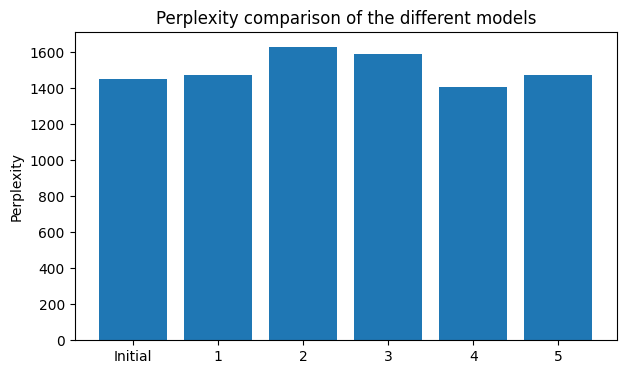

In [173]:
#plot perplexity for different model parameters
plt.figure(figsize=(7, 4))
plt.bar(["Initial", "1", "2", "3", "4", "5"], [test_perplexity, test_perplexity_1, test_perplexity_2, test_perplexity_3, test_perplexity_4, test_perplexity_5])
plt.ylabel("Perplexity")
plt.title("Perplexity comparison of the different models")
plt.show()